In [2]:
import glob
import os
from nilearn.image import binarize_img, concat_imgs, mean_img, threshold_img, math_img
from nilearn.plotting import plot_roi, plot_img, plot_stat_map
from nilearn.datasets import load_mni152_template
from nilearn.masking import apply_mask
from matplotlib import colors
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## RT conjunction

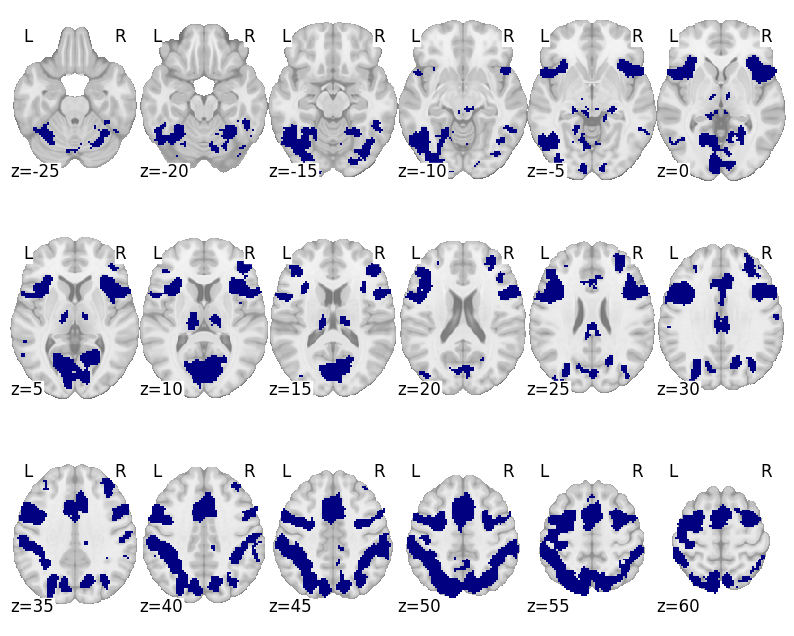

In [21]:
# change if you're not directly on oak and to a figure path that works for you
outdir = '/home/poldrack/oak/data/uh2/aim1_mumford/output'

fig_output_file_dir = '/home/poldrack/Dropbox/Documents/Presentations/talks-BrainBehaviorAssociation/talk/images'
fig_output_file_path = os.path.join(fig_output_file_dir, 'conjunction_avg_rt_effect_across_7tasks_3row_plot.png')


files_for_conjunction = glob.glob(
    f'{outdir}/*lev2*/*contrast_response_time*one_sampt/'
    '*corrp_fstat*'
)

dat_4d = concat_imgs(files_for_conjunction)
dat_4d_bin = binarize_img(dat_4d, threshold = 0.95)
dat_bin_avg = mean_img(dat_4d_bin)
dat_conj = binarize_img(dat_bin_avg, threshold = 1)

def plot_rows(data):
    fig, axs = plt.subplots(3, figsize=(10, 8))
    plot_roi(data, alpha=1, view_type='continuous', 
        display_mode='z', cut_coords = tuple(np.arange(-25, 5, 5)), 
        annotate=True, axes=axs[0])
    plot_roi(data, alpha=1, view_type='continuous', 
        display_mode='z', cut_coords = tuple(np.arange(5, 35, 5)), 
        annotate=True, axes=axs[1])
    plot_roi(data, alpha=1, view_type='continuous', 
        display_mode='z', cut_coords = tuple(np.arange(35, 65, 5)), 
        annotate=True,  axes=axs[2])

    return fig

fig = plot_rows(dat_conj)


## Stroop activation

If you go here: 
/oak/stanford/groups/russpold/data/uh2/aim1_mumford/output/stroop_lev2_output
you'll find all the level 2 analyses for stroop.  The directory names tell the following
stroop_lev1_contrast_LOWER_LEVEL_CONTRAST_rtmod_RT_MODEL_lev2_model_GROUP_MODEL

so the ConsDurNoRT group average output is here:
stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_no_rt_lev2_model_one_sampt

The ConsDurRT group average is here:
stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_rt_uncentered_lev2_model_one_sampt

Both directories have an f-stat (2-sided 1-sample t-test), which I'd combine with the uncorrected t-stats if you need the signs of things.  The directories should have all the info you need, including the randomise call.

The RT correlations models are 
stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_no_rt_lev2_model_rt_diff_new_omission
stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_rt_uncentered_lev2_model_rt_diff_new_omission

"new_omission" is what I ran the other day for you to make sure the recent omissions that are clearly bad in some tasks didn't impact the results BUT the paper conjunction has those omitted subjects included still.  I don't think it'll make a difference.  I've completed the MRIQC checks and need to check the fmriprep output files for my questionables from mriqc.  Hopefully I will finish today or tomorrow.  I highly doubt these omissions will have any impact on the conjunction analysis, since that's a 1-sample t-test.  If you think I should redo all of this prior to uploading the preprint and submitting, let me know.

You can peek in the desmat.mat/.con files as a reality check, but the t/fstat1 are for the intercept (ignore) and the t/fstat2 are for the RT difference, which is what you're interested in.  Again, I only ran corrected stats for the 2-sided test (f-test) and perhaps the >0 t-stats are in there too.  So, you'll focus on t/fstat2.




In [14]:
stroop_level2_dir = '/home/poldrack/oak/data/uh2/aim1_mumford/output/stroop_lev2_output'

stroop_output_dir = {
    'ConsDurNoRT': os.path.join(stroop_level2_dir, 'stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_no_rt_lev2_model_one_sampt'),
    'ConsDurRT': os.path.join(stroop_level2_dir, 'stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_rt_uncentered_lev2_model_one_sampt'),
    'ConsDurNoRT_corr': os.path.join(stroop_level2_dir, 'stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_no_rt_lev2_model_rt_diff_new_omission'),
    'ConsDurRT_corr': os.path.join(stroop_level2_dir, 'stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_rt_uncentered_lev2_model_rt_diff_new_omission')
}

fstats = {}
tstats = {}
for model, dir in stroop_output_dir.items():
    fstats[model] = glob.glob(f'{dir}/*corrp_fstat1.nii.gz')[0]
    # get the uncorrected t stat
    tstats[model] = [i for i in glob.glob(f'{dir}/*tstat1.nii.gz') if i.find('corrp') < 0][0]


/tmp/ipykernel_304979/2850580997.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


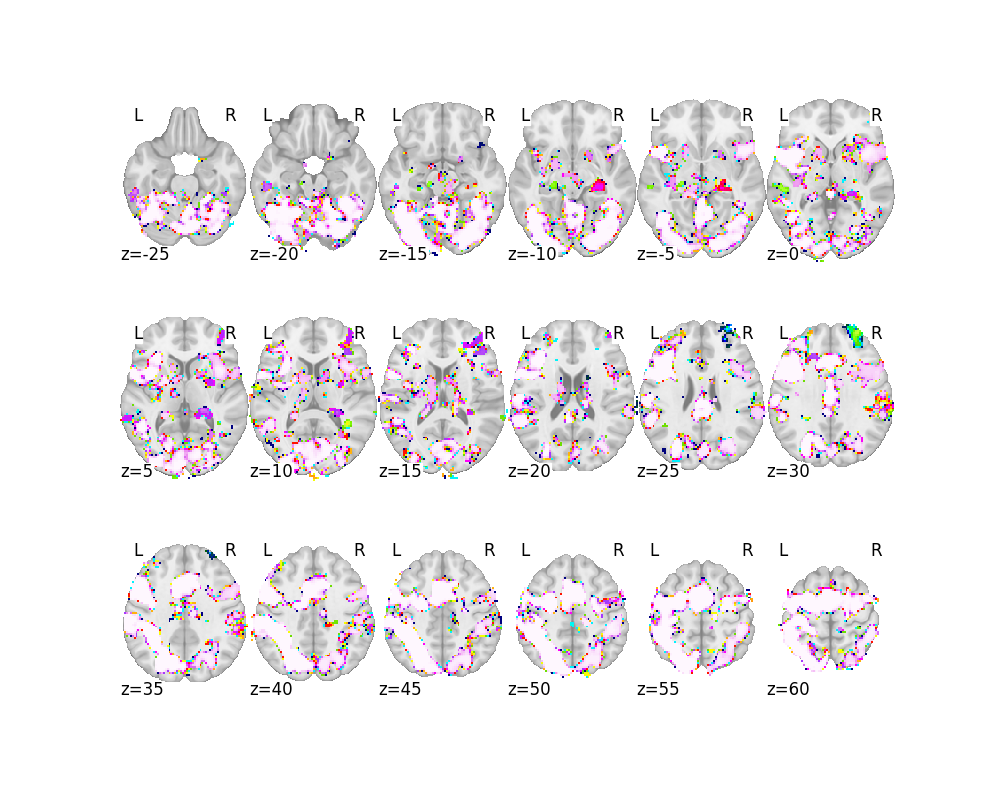

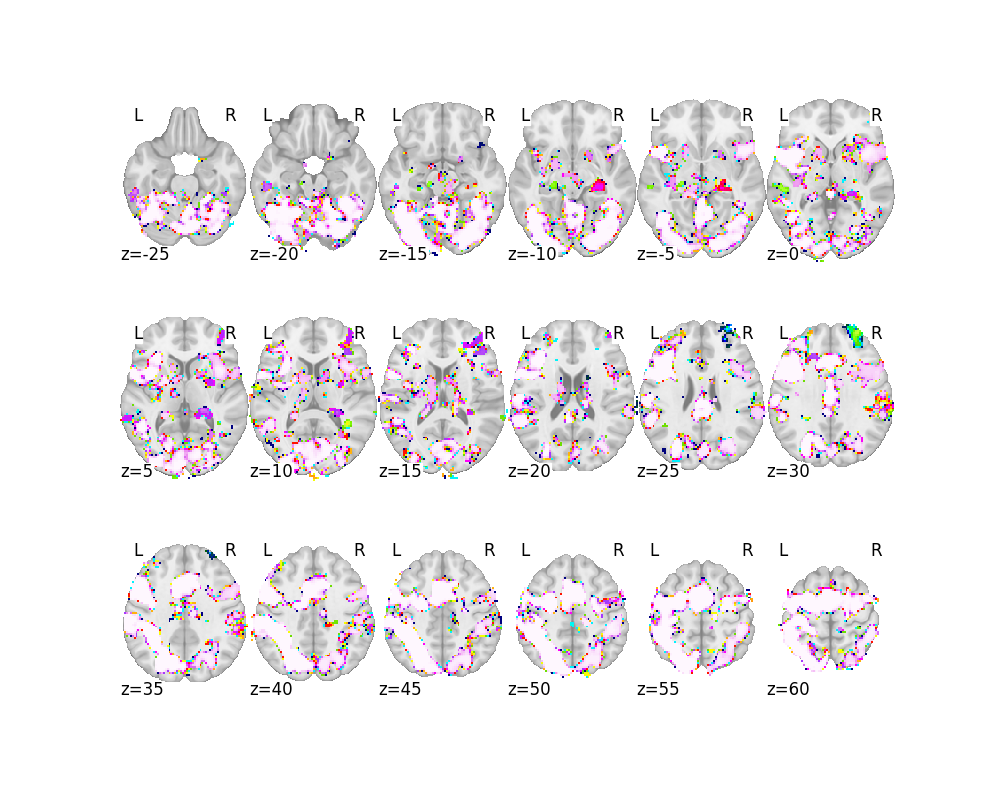

In [20]:
fig = plot_rows(fstats['ConsDurNoRT'])


In [7]:
ls /home/poldrack/oak/data/uh2/aim1_mumford/output/stroop_lev2_output/stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_no_rt_lev2_model_one_sampt


desmat.con
desmat.fts
model_summary.html
randomise_call.batch*
randomise_output_model_one_sampt_fstat1.nii.gz
randomise_output_model_one_sampt_tfce_corrp_fstat1.nii.gz
randomise_output_model_one_sampt_tfce_corrp_tstat1.nii.gz
randomise_output_model_one_sampt_tstat1.nii.gz
stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_no_rt_mask.nii.gz
stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_no_rt.nii.gz
